# Market Basket Analysis 

In [16]:
# import libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules

In [17]:
#load the dataset
data = pd.read_csv(r'C:\Users\Rebecca\Desktop\market basket analysis project\Retail_Transactions_Dataset.csv')

In [18]:
#first 5 rows of the dataset
data.head()

,Transaction_ID,Date,Customer_Name,Product,Total_Items,Total_Cost,Payment_Method,City,Store_Type,Discount_Applied,Customer_Category,Season,Promotion
0,1000000000,2022-01-21 06:27:29,Stacey Price,"['Ketchup', 'Shaving Cream', 'Light Bulbs']",3,71.65,Mobile Payment,Los Angeles,Warehouse Club,True,Homemaker,Winter,NaN
1,1000000001,2023-03-01 13:01:21,Michelle Carlson,"['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...",2,25.93,Cash,San Francisco,Specialty Store,True,Professional,Fall,BOGO (Buy One Get One)
2,1000000002,2024-03-21 15:37:04,Lisa Graves,['Spinach'],6,41.49,Credit Card,Houston,Department Store,True,Professional,Winter,NaN
3,1000000003,2020-10-31 09:59:47,Mrs. Patricia May,"['Tissues', 'Mustard']",1,39.34,Mobile Payment,Chicago,Pharmacy,True,Homemaker,Spring,NaN
4,1000000004,2020-12-10 00:59:59,Susan Mitchell,['Dish Soap'],10,16.42,Debit Card,Houston,Specialty Store,False,Young Adult,Winter,Discount on Selected Items


# Data Preparation

In [19]:
#check the shape of the dataset
data.shape

(1000000, 13)

In [20]:
#info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Transaction_ID     1000000 non-null  int64  
 1   Date               1000000 non-null  object 
 2   Customer_Name      1000000 non-null  object 
 3   Product            1000000 non-null  object 
 4   Total_Items        1000000 non-null  int64  
 5   Total_Cost         1000000 non-null  float64
 6   Payment_Method     1000000 non-null  object 
 7   City               1000000 non-null  object 
 8   Store_Type         1000000 non-null  object 
 9   Discount_Applied   1000000 non-null  bool   
 10  Customer_Category  1000000 non-null  object 
 11  Season             1000000 non-null  object 
 12  Promotion          666057 non-null   object 
dtypes: bool(1), float64(1), int64(2), object(9)
memory usage: 92.5+ MB


In [21]:
#check sumary statistics of the dataset
data.describe()

,Transaction_ID,Total_Items,Total_Cost
count,1.000000e+06,1000000.000000,1000000.000000
mean,1.000500e+09,5.495941,52.455220
std,2.886753e+05,2.871654,27.416989
min,1.000000e+09,1.000000,5.000000
25%,1.000250e+09,3.000000,28.710000
50%,1.000500e+09,5.000000,52.420000
75%,1.000750e+09,8.000000,76.190000
max,1.001000e+09,10.000000,100.000000


In [22]:
#check for null values in the dataset
data.isnull().sum()

Transaction_ID            0
Date                      0
Customer_Name             0
Product                   0
Total_Items               0
Total_Cost                0
Payment_Method            0
City                      0
Store_Type                0
Discount_Applied          0
Customer_Category         0
Season                    0
Promotion            333943
dtype: int64

In [23]:
#remove the column with missing values
data = data.dropna(axis=1)

In [24]:
data.isnull().sum()

Transaction_ID       0
Date                 0
Customer_Name        0
Product              0
Total_Items          0
Total_Cost           0
Payment_Method       0
City                 0
Store_Type           0
Discount_Applied     0
Customer_Category    0
Season               0
dtype: int64

In [25]:
#check for duplicated values in the dataset
data.duplicated().sum()

0

In [26]:
#remove duplicated values
data = data.drop_duplicates()

In [27]:
# Convert the 'Product' column from string representation of list to actual list if needed
import ast
if isinstance(data['Product'].iloc[0], str):
    data['Product'] = data['Product'].apply(ast.literal_eval)

# Explode the 'Product' column so each row has a single product
data_exploded = data.explode('Product')

# Convert transactional data to basket data
basket_data = (
    data_exploded
    .groupby(['Transaction_ID', 'Product'])['Total_Items']
    .sum().unstack().reset_index().fillna(0)
    .set_index('Transaction_ID')
)

# Convert the values to 1 and 0
basket = basket_data.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\Rebecca\AppData\Local\Temp\ipykernel_20008\1127717595.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket_data.applymap(lambda x: 1 if x > 0 else 0)


In [28]:
#save cleaned data to a new CSV file
basket.to_csv(r'C:\Users\Rebecca\Desktop\market basket analysis project\cleaned_basket_data.csv')

# Exploritory Data Analysis

In [29]:
#Top selling products
top_selling_products = basket.sum().sort_values(ascending=False).head(10)
print("Top Selling Products:")
print(top_selling_products)


Top Selling Products:
Product
Toothpaste       70949
Ice Cream        36485
Soap             36438
Orange           36342
Jam              36336
Soda             36324
Cleaning Rags    36279
Deodorant        36278
Air Freshener    36266
Banana           36224
dtype: int64


In [30]:
# visualize the top selling products
fig = px.bar(top_selling_products, 
             x=top_selling_products.index, 
             y=top_selling_products.values, 
             labels={'x': 'Products', 'y': 'Total Items Sold'},
             title='Top Selling Products')
fig.update_layout(xaxis_title='Products', yaxis_title='Total Items Sold')
fig.show()


In [31]:
# Season vs. Customer Category & Total Items (Grouped Bar Chart) using plotly
season_customer_category = data.groupby(['Season', 'Customer_Category'])['Total_Items'].sum().reset_index()
fig = px.bar(season_customer_category, 
             x='Season', 
             y='Total_Items', 
             color='Customer_Category', 
             barmode='group',
             labels={'Season': 'Season', 'Total_Items': 'Total Items'},
             title='Total Items by Season and Customer Category')
fig.update_layout(xaxis_title='Season', yaxis_title='Total Items')
fig.show()


In [32]:
# Top Customer Category by Total Items Purchased
top_customer_category = data.groupby('Customer_Category')['Total_Items'].sum().sort_values(ascending=False).head(10)
print("Top Customer Categories by Total Items Purchased:")
print(top_customer_category)

Top Customer Categories by Total Items Purchased:
Customer_Category
Homemaker         690108
Senior Citizen    689355
Retiree           688579
Teenager          687960
Student           686230
Middle-Aged       685671
Young Adult       684619
Professional      683419
Name: Total_Items, dtype: int64


In [33]:
#visualize the top customer categories
fig = px.bar(top_customer_category, 
             x=top_customer_category.index, 
             y=top_customer_category.values, 
             labels={'x': 'Customer Category', 'y': 'Total Items Purchased'},
             title='Top Customer Categories by Total Items Purchased')
fig.update_layout(xaxis_title='Customer Category', yaxis_title='Total Items Purchased')
fig.show()

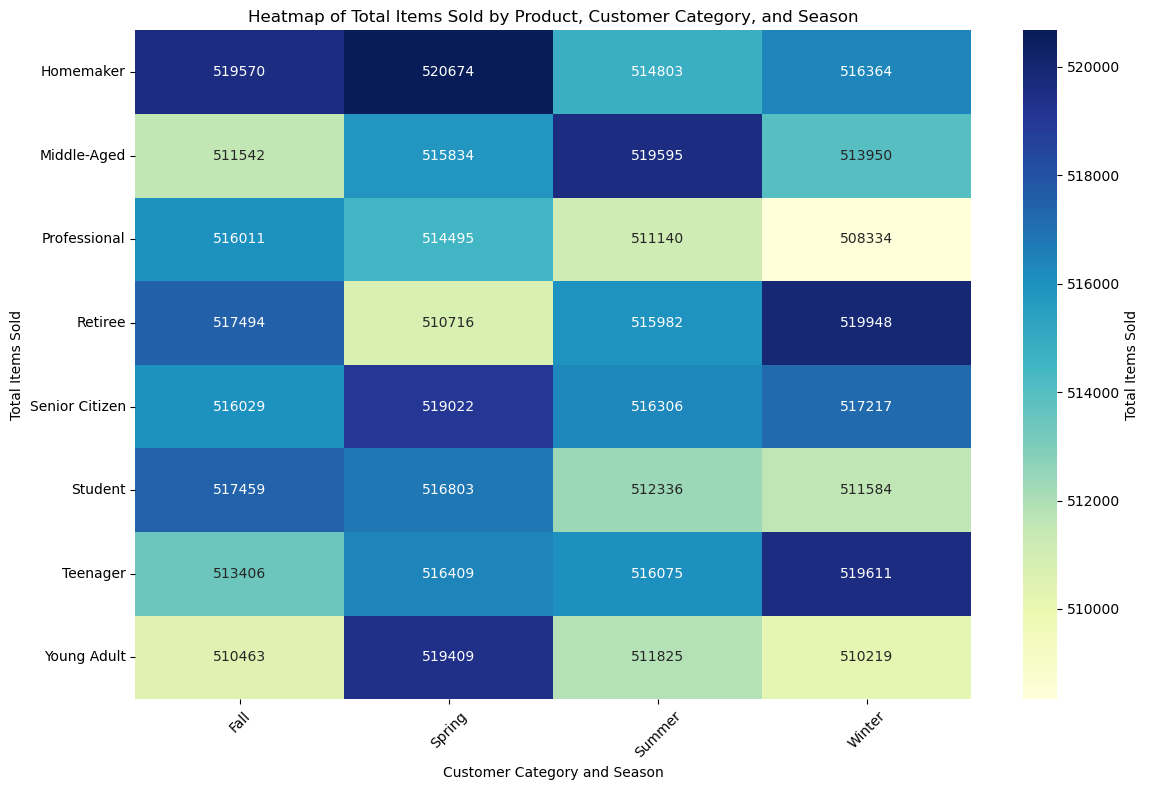

In [34]:
# heatmap for revenue By Product and Customer Category and Season
heatmap_data = data_exploded.groupby(['Customer_Category', 'Season'])['Total_Items'].sum().unstack().fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap='YlGnBu', cbar_kws={'label': 'Total Items Sold'})
plt.title('Heatmap of Total Items Sold by Product, Customer Category, and Season')
plt.xlabel('Customer Category and Season')
plt.ylabel('Total Items Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Transformation

In [ ]:
from mlxtend.preprocessing import TransactionEncoder
import ast

# Parse each transaction string into a list of products
parsed_transactions = [ast.literal_eval(t[0]) if isinstance(t, list) and isinstance(t[0], str) else t for t in transactions]

te = TransactionEncoder()
te_ary = te.fit(parsed_transactions).transform(parsed_transactions)


In [46]:
# Fit and transform the data
te_ary = te.fit(data['Product']).transform(data['Product'])


In [47]:
# Create a DataFrame from the transformed data
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

In [50]:
# Convert basket_data to one-hot encoded DataFrame (1 if item present, 0 otherwise)
basket_onehot = basket_data.map(lambda x: 1 if x > 0 else 0)

In [51]:
#create a new column for Transactuon_ID and Product
basket_onehot['Transaction_ID'] = data_exploded['Transaction_ID'].unique()

In [52]:
print("One-hot encoded basket data:")
basket_onehot.head()

One-hot encoded basket data:


Product,Air Freshener,Apple,BBQ Sauce,Baby Wipes,Banana,Bath Towels,Beef,Bread,Broom,Butter,...,Toothbrush,Toothpaste,Trash Bags,Trash Cans,Tuna,Vacuum Cleaner,Vinegar,Water,Yogurt,Transaction_ID
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
1000000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000000000
1000000001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1000000001
1000000002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000000002
1000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000000003
1000000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000000004


In [53]:
# Use the last digit of the index (Transaction_ID) as the new Transaction_ID column in basket_onehot
basket_onehot['Transaction_ID'] = basket_onehot.index.astype(str).str[-1].astype(int)


In [54]:
basket_onehot = basket_onehot.astype(bool).astype(int)

In [55]:
basket_onehot.head()

Product,Air Freshener,Apple,BBQ Sauce,Baby Wipes,Banana,Bath Towels,Beef,Bread,Broom,Butter,...,Toothbrush,Toothpaste,Trash Bags,Trash Cans,Tuna,Vacuum Cleaner,Vinegar,Water,Yogurt,Transaction_ID
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
1000000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000000001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [56]:
#save the data transformation to a new CSV file
basket_onehot.to_csv(r'C:\Users\Rebecca\Desktop\market basket analysis project\basket_onehot.csv', index=False)

# Apriori Model

*  Apriori algorithm finds frequent product combinations; association rules help identify strong product affinities for bundling or promotions

In [57]:
#import apriori model
from mlxtend.frequent_patterns import apriori, association_rules

In [58]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(basket_onehot, min_support=0.5, use_colnames=True)


c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [60]:
# Count item frequency
item_counts = basket_onehot.sum(axis=0)
# Keep items that appear in at least 10 transactions
frequent_items = item_counts[item_counts >= 10].index
basket_onehot_reduced = basket_onehot[frequent_items]

# Use 10% of the data for memory efficiency
basket_sample = basket_onehot_reduced.sample(frac=0.1, random_state=42)

# Lower the min_support to find frequent itemsets on a reduced sample to avoid MemoryError
frequent_itemsets = apriori(basket_sample, min_support=0.01, use_colnames=True)

if not frequent_itemsets.empty:
	rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)
	print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
else:
	# If no frequent itemsets are found, try reducing the number of columns (items) further
	if frequent_itemsets.empty:
		# Sort items by frequency and keep only the top 20 most frequent items
		top_items = item_counts.sort_values(ascending=False).head(20).index
		basket_sample_top = basket_sample[top_items]
		frequent_itemsets = apriori(basket_sample_top, min_support=0.01, use_colnames=True)
		if not frequent_itemsets.empty:
			rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)
			print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
		else:
			print("No frequent itemsets found even after reducing to top 20 items. Try lowering min_support further or reducing items more.")


c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



         antecedents       consequents  support  confidence      lift
0    (Air Freshener)  (Transaction_ID)  0.03359    0.915010  1.016147
1            (Apple)  (Transaction_ID)  0.03216    0.896321  0.995392
2        (BBQ Sauce)  (Transaction_ID)  0.03314    0.903736  1.003627
3       (Baby Wipes)  (Transaction_ID)  0.03248    0.901471  1.001112
4           (Banana)  (Transaction_ID)  0.03285    0.901729  1.001399
..               ...               ...      ...         ...       ...
76            (Tuna)  (Transaction_ID)  0.03114    0.902609  1.002375
77  (Vacuum Cleaner)  (Transaction_ID)  0.03164    0.897080  0.996235
78         (Vinegar)  (Transaction_ID)  0.03273    0.907906  1.008258
79           (Water)  (Transaction_ID)  0.03255    0.905928  1.006061
80          (Yogurt)  (Transaction_ID)  0.03290    0.899153  0.998537

[81 rows x 5 columns]


In [62]:
# Count item frequency
item_counts = basket_onehot.sum(axis=0)
# Keep items that appear in at least 10 transactions
frequent_items = item_counts[item_counts >= 10].index
basket_onehot_reduced = basket_onehot[frequent_items]
print("Reduced basket data shape:", basket_onehot_reduced.shape)


Reduced basket data shape: (1000000, 82)


In [63]:
# Use 10% of the data
basket_sample = basket_onehot_reduced.sample(frac=0.1, random_state=42)

In [65]:
from mlxtend.frequent_patterns import apriori

# Use the correct input DataFrame for apriori
frequent_itemsets = apriori(basket_onehot_reduced, min_support=0.6, use_colnames=True)
print(frequent_itemsets)



c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



   support          itemsets
0      0.9  (Transaction_ID)


In [66]:
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.6)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [67]:
# Use a reduced sample to avoid MemoryError
frequent_itemsets = apriori(basket_sample, min_support=0.01, use_colnames=True)

c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [68]:
basket_onehot.head()

Product,Air Freshener,Apple,BBQ Sauce,Baby Wipes,Banana,Bath Towels,Beef,Bread,Broom,Butter,...,Toothbrush,Toothpaste,Trash Bags,Trash Cans,Tuna,Vacuum Cleaner,Vinegar,Water,Yogurt,Transaction_ID
Transaction_ID,,,,,,,,,,,,,,,,,,,,,
1000000000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000000001,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1000000004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [74]:
from mlxtend.frequent_patterns import apriori

apriori(basket_onehot, min_support=0.6)

c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets
0,0.9,(81)


In [73]:
# Use a smaller sample to avoid MemoryError
sample_df = basket_sample.copy()

# Remove 'Transaction_ID' column if present
if 'Transaction_ID' in sample_df.columns:
    basket_for_apriori = sample_df.drop(columns=['Transaction_ID'])
else:
    basket_for_apriori = sample_df

# Run Apriori on the sample
frequent_itemsets = apriori(basket_for_apriori, min_support=0.01, use_colnames=True)
print(frequent_itemsets)

c:\Users\Rebecca\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



    support          itemsets
0   0.03671   (Air Freshener)
1   0.03588           (Apple)
2   0.03667       (BBQ Sauce)
3   0.03603      (Baby Wipes)
4   0.03643          (Banana)
..      ...               ...
76  0.03450            (Tuna)
77  0.03527  (Vacuum Cleaner)
78  0.03605         (Vinegar)
79  0.03593           (Water)
80  0.03659          (Yogurt)

[81 rows x 2 columns]


In [81]:
# Group items bought together by aggregating the 'Product' column for each Transaction_ID
items_bought_together = data_exploded.groupby('Transaction_ID')['Product'].apply(list)

# Display the first 10 transactions with their grouped products
items_bought_together.head(10)

Transaction_ID
1000000000                [Ketchup, Shaving Cream, Light Bulbs]
1000000001        [Ice Cream, Milk, Olive Oil, Bread, Potatoes]
1000000002                                            [Spinach]
1000000003                                   [Tissues, Mustard]
1000000004                                          [Dish Soap]
1000000005                                [Toothpaste, Chicken]
1000000006     [Honey, BBQ Sauce, Soda, Olive Oil, Garden Hose]
1000000007    [Syrup, Trash Cans, Pancake Mix, Water, Mayonn...
1000000008                                   [Insect Repellent]
1000000009                             [Soap, Baby Wipes, Soda]
Name: Product, dtype: object

In [82]:
#use scatter plot to group items according to their support percentage
fig = px.scatter(frequent_itemsets_plot, 
                 x='itemsets', 
                 y='support', 
                 size='support', 
                 color='support',
                 labels={'itemsets': 'Itemsets', 'support': 'Support'},
                 title='Frequent Itemsets Scatter Plot by Support')
fig.update_layout(xaxis_title='Itemsets', yaxis_title='Support')
fig.show()


In [90]:
#save the model as Apriori model
frequent_itemsets.to_csv(r'C:\Users\Rebecca\Desktop\market basket analysis project\frequent_itemsets.csv', index=False)